# COMP0005 - GROUP COURSEWORK 2023-24
# Gesture Recognition via Convex Hull 

Use the cell below for all python code needed to realise the **Jarvis march algorithm** (including auxiliary data structures and functions needed by this algorithm - if any). The `jarvismarch()` function itself should take as input parameter a list of 2D points (`inputSet`), and return the subset of such points (`outputSet`) that lie on the convex hull.

In [1]:
def orientation(p1, p2, p3):
    # = 0 <- collinear; > 0 <- clockwise; < 0 <- counterclockwise
    return (p2[1] - p1[1]) * (p3[0] - p2[0]) - (p2[0] - p1[0]) * (p3[1] - p2[1])

def distanceSquared(p1, p2):
    return ((p1[0] - p2[0]) ** 2) + ((p1[1] - p2[1]) ** 2)

def jarvismarch(inputSet):
    """
    Returns the list of points that lie on the convex hull (jarvis march algorithm)
            Parameters:
                    inputSet (list): a list of 2D points

            Returns:
                    outputSet (list): a list of 2D points
    """

    if len(inputSet) < 3:
        return inputSet

    # find by lowest x-coordinate & highest y-coordinate
    leftMostCoord, leftMostPoint = inputSet[0][0], inputSet[0]
    for index, point in enumerate(inputSet):
        if point[0] < leftMostCoord or (point[0] == leftMostCoord and point[1] > leftMostPoint[1]):
            leftMostCoord, leftMostPoint = point[0], point
    outputSet = [leftMostPoint]
    nextHullPoint = leftMostPoint

    while True:

        # take any point that's not nextHullPoint
        referencePoint = inputSet[0] if inputSet[0] != nextHullPoint else inputSet[1]

        for eachPoint in inputSet:

            if eachPoint == nextHullPoint:
                continue

            direction = orientation(nextHullPoint, referencePoint, eachPoint)
            # eachPoint more counterclockwise than referencePoint or referencePoint & eachPoint collinear (take farthest point)
            if (direction < 0) or (direction == 0 and distanceSquared(nextHullPoint, eachPoint) > distanceSquared(nextHullPoint, referencePoint)):
                referencePoint = eachPoint

        nextHullPoint = referencePoint

        if nextHullPoint == leftMostPoint: # closed polygon - don't need to reappend to outputSet
            break

        outputSet.append(nextHullPoint)

    return outputSet

Use the cell below for all python code needed to realise the **Graham scan** algorithm (including auxiliary data structures and functions needed by this algorithm - if any). The `grahamscan()` function itself should take as input parameter a list of 2D points (`inputSet`), and return the subset of such points that lie on the convex hull (`outputSet`).

In [2]:
def grahamscan(inputSet):
    """
    Returns the list of points that lie on the convex hull (graham scan algorithm)
            Parameters:
                    inputSet (list): a list of 2D points

            Returns:
                    outputSet (list): a list of 2D points
    """

    if len(inputSet) < 3:
        return inputSet

    # find by lowest y-coordinate & lowest x-coordinate
    lowestCoord, lowestPointIndex = inputSet[0][1], 0
    for index, point in enumerate(inputSet):
        if point[1] < lowestCoord or (point[1] == lowestCoord and point[0] < inputSet[lowestPointIndex][0]):
            lowestCoord, lowestPointIndex = point[1], index
    lowestPoint = inputSet[lowestPointIndex]

    # sort points based on polar angle w/ respect to lowestPoint - using Timsort
    inputSet = sorted(inputSet, key = lambda point: (math.atan2(point[1] - lowestPoint[1], point[0] - lowestPoint[0]), distanceSquared(lowestPoint, point)))

    outputSet = [inputSet[0], inputSet[1]]

    for point in inputSet[2:]:

        while len(outputSet) > 1 and orientation(outputSet[-2], outputSet[-1], point) >= 0: # not counterclockwise
            outputSet.pop()

        outputSet.append(point)

    return outputSet

Use the cell below for all python code needed to realise the **Chen's** algorithm (including auxiliary data structures and functions needed by this algorithm - if any). The `chen()` function itself should take as input parameter a list of 2D points (`inputSet`), and return the subset of such points that lie on the convex hull (`outputSet`).

In [3]:
def getSmallHulls(inputSet, m):
    partitions = [inputSet[i : i + m] for i in range(0, len(inputSet), m)]
    return [grahamscan(partition) for partition in partitions]

def binarySearchLowestPoint(smallHulls, currentHullIndex, referencePoint):
    hullPointsLen = len(smallHulls[currentHullIndex])
    leftPointer = 0
    rightPointer = hullPointsLen
    
    prevTurn = orientation(referencePoint, smallHulls[currentHullIndex][0], smallHulls[currentHullIndex][-1])
    nextTurn = orientation(referencePoint, smallHulls[currentHullIndex][0], smallHulls[currentHullIndex][(leftPointer + 1) % hullPointsLen])

    while leftPointer < rightPointer:

        middle = (leftPointer + rightPointer) // 2
        
        beforeMiddle = orientation(referencePoint, smallHulls[currentHullIndex][(middle - 1) % hullPointsLen], smallHulls[currentHullIndex][middle])
        afterMiddle = orientation(referencePoint, smallHulls[currentHullIndex][middle], smallHulls[currentHullIndex][(middle + 1) % hullPointsLen])
        nextToMiddle = orientation(referencePoint, smallHulls[currentHullIndex][leftPointer], smallHulls[currentHullIndex][middle])

        if beforeMiddle > 0 and afterMiddle <= 0:
            return middle

        elif (nextToMiddle < 0 and (nextTurn > 0 or ((prevTurn < 0 and nextTurn < 0) or (prevTurn > 0 and nextTurn > 0) or (prevTurn == 0 and nextTurn == 0)))) or (nextToMiddle > 0 and beforeMiddle < 0):
            rightPointer = middle

        else:
            leftPointer = middle + 1
            prevTurn = -afterMiddle

            if leftPointer < hullPointsLen:
                nextTurn = orientation(referencePoint, smallHulls[currentHullIndex][leftPointer], smallHulls[currentHullIndex][(leftPointer + 1) % hullPointsLen])
            else:
                return hullPointsLen - 1

    return leftPointer

def findNextPoint(smallHulls, possiblePoints, referencePointHullIndex, referencePointIndex): # modified jarvismarch
    referencePoint = smallHulls[referencePointHullIndex][referencePointIndex]
    nextPointHullIndex, nextPointIndex = referencePointHullIndex, (referencePointIndex + 1) % len(smallHulls[referencePointHullIndex])

    for hullIndex, pointIndex in possiblePoints:

        if hullIndex == referencePointHullIndex:
            continue

        direction = orientation(referencePoint, smallHulls[nextPointHullIndex][nextPointIndex], smallHulls[hullIndex][pointIndex])

        if pointIndex < len(smallHulls[hullIndex]):
            # clockwise or collinear & further
            if (direction > 0) or (direction == 0 and distanceSquared(referencePoint, smallHulls[hullIndex][pointIndex]) > distanceSquared(referencePoint, smallHulls[nextPointHullIndex][nextPointIndex])):
                nextPointHullIndex, nextPointIndex = hullIndex, pointIndex

    return nextPointHullIndex, nextPointIndex

def tryAlgorithm(inputSet, m):
    smallHulls = getSmallHulls(inputSet, m)

    # find by lowest y-coordinate & lowest x-coordinate
    lowestPointHullIndex, lowestPointIndex = 0, 0
    for hullIndex in range(len(smallHulls)):
        for pointIndex in range(len(smallHulls[hullIndex])):
            currentPoint, lowestPoint = smallHulls[hullIndex][pointIndex], smallHulls[lowestPointHullIndex][lowestPointIndex]
            if currentPoint[1] < lowestPoint[1] or (currentPoint[1] == lowestPoint[1] and currentPoint[0] < lowestPoint[0]):
                lowestPointHullIndex, lowestPointIndex = hullIndex, pointIndex

    outputSet = [(lowestPointHullIndex, lowestPointIndex)]

    for _ in range(m):
        possibleNextPoints = []

        for hullIndex in range(len(smallHulls)):

            if hullIndex == lowestPointHullIndex:
                continue

            else:
                toAppendIndex = binarySearchLowestPoint(smallHulls, hullIndex, smallHulls[lowestPointHullIndex][lowestPointIndex])
                possibleNextPoints.append((hullIndex, toAppendIndex))

        lowestPointHullIndex, lowestPointIndex = findNextPoint(smallHulls, possibleNextPoints, lowestPointHullIndex, lowestPointIndex)
        outputSet.append((lowestPointHullIndex, lowestPointIndex))

        if outputSet[0] == outputSet[-1]: # closed polygon
            for i in range(len(outputSet)):
                outputSet[i] = smallHulls[outputSet[i][0]][outputSet[i][1]] # want actual points, not indexes
            return outputSet[:-1]

    return []

def chen(inputSet):
    """
    Returns the list of points that lie on the convex hull (chen's algorithm)
            Parameters:
                    inputSet (list): a list of 2D points

            Returns:
                    outputSet (list): a list of 2D points
    """

    n = len(inputSet)

    if n < 3:
        return inputSet

    t = round(math.log(math.log(n, 2), 2) - 1) # adapted to be faster for 2D coordinates

    while True:

        outputSet = tryAlgorithm(inputSet, max(2 ** (2 ** t), int(math.sqrt(n)))) # adapted to be faster for 2D coordinates

        if len(outputSet) == 0: # m was wrong - need to try again with larger m
            t += 1
        else: # correct - outputSet found
            break

    return outputSet

Use the cell below to implement the **synthetic data generator** needed by your experimental framework (including any auxiliary data structures and functions you might need - be mindful of code readability and reusability).

In [4]:
class TestDataGenerator():
    """
    A class to represent a synthetic data generator.

    Attributes
    ----------

    xRange (tuple): A tuple (min, max) specifying the range of x-values. (0, 32767) by default.

    yRange (tuple): A tuple (min, max) specifying the range of y-values. (0, 32767) by default.

    points (list):  A list of 2D points, where each point is represented as a tuple (x, y).

    Methods
    -------

    generateRandomPoints(numPoints):
        Generates numPoints number of random unique points within the attributes xRange and yRange.

    generatePolygonPointsInt(n, radius, offset):
        Generates integer points of a polygon with parameter n sides, radius of parameter radius, and
        centre of parameter offset (typically the same as radius).

    generatePolygonInsideInt(vertices, count):
        Generates parameter count number of integer points that lie within a polygon with vertices of
        parameter vertices.

    generateParticularPointsInt(n, h, radius):
        Generates points forming a regular polygon and additional points inside the polygon area by
        calling methods generatePolygonPointsInt() and generatePolygonInsideInt(), ensuring that the
        total number of points created (n), and the total number of points that lie on the convex
        hull (h), do not accidentally change. Guarantees the polygon will be an approximation of a
        circle of radius equal to parameter radius.

    generateCollinearPoints(n, option):
        Generates n collinear points of 3 different types which are determined based on parameter
        option. The types are the lines with the equations: y = x; y = a; & x = a.

    """

    def __init__(self, xRange = (0, 32767), yRange = (0, 32767)):
        self.xRange = xRange
        self.yRange = yRange
        self.points = []

    def generateRandomPoints(self, numPoints):
        generatedPoints = dict()

        for _ in range(numPoints):

            newPoint = (random.randint(self.xRange[0], self.xRange[1]), random.randint(self.yRange[0], self.yRange[1]))
            while newPoint in generatedPoints: # dictionary lookup time complexity O(1)
                newPoint = (random.randint(self.xRange[0], self.xRange[1]), random.randint(self.yRange[0], self.yRange[1]))

            generatedPoints[newPoint] = 1

        self.points = [key for key in generatedPoints.keys()]

    def generatePolygonPointsInt(self, n, radius, offset):
        vertices = []

        for i in range(n):

            angle = 2 * math.pi * i / n  
            x = int(round(radius * math.cos(angle))) + offset
            y = int(round(radius * math.sin(angle))) + offset

            vertices.append((x, y))

        return vertices

    def generatePolygonInsideInt(self, vertices, count):
        internalPoints = []

        for _ in range(count):

            triangle = random.sample(vertices, 3)

            # random weights for barycentric coordinates
            weights = [random.random() for _ in range(3)]
            weightSum = sum(weights)
            # normalise to sum up to 1
            weights = [w / weightSum for w in weights]

            # calculate barycentric coordinates for the point
            point = [0, 0]

            for i in range(3):
                point[0] += int(round(triangle[i][0] * weights[i]))
                point[1] += int(round(triangle[i][1] * weights[i]))

            internalPoints.append(point)

        return internalPoints

    def generateParticularPointsInt(self, n, h, radius):
        if h <= 2:
            # random points within a circle
            return [(random.uniform(0, 2 * radius), random.uniform(0, 2 * radius)) for _ in range(2)]

        vertices = self.generatePolygonPointsInt(h, radius, radius)
        remainingPoints = n - h # number of points to be generated inside polygon
        internalPoints = self.generatePolygonInsideInt(vertices, remainingPoints)

        # combine all generated points into one list
        allPoints = vertices + internalPoints

        self.points = allPoints

    def generateCollinearPoints(self, n, option = "y=x"):
        if option == "y=x":
            firstX, firstY = (self.xRange[1] + self.xRange[0]) // 2, (self.yRange[1] + self.yRange[0]) // 2
            points = [(firstX, firstY)]

            for i in range(1, min(((n - 1) // 2) + 1, firstX, firstY)):
                points.append((points[0][0] + i, points[0][1] + i))
                points.append((points[0][0] - i, points[0][1] - i))

            if (n - 1) % 2 != 0:
                points.append((points[-1][0] + 1, points[-1][1] + 1))

        elif option == "horizontal":
            firstX, firstY = 0, random.randint(self.yRange[0], self.yRange[1])
            points = [(firstX, firstY)]

            for i in range(1, n):
                points.append((points[0][0] + i, firstY))

        else: # vertical
            firstX, firstY = random.randint(self.xRange[0], self.xRange[1]), 0
            points = [(firstX, firstY)]

            for i in range(1, n):
                points.append((firstX, points[0][1] + i))

        self.points = points
        random.shuffle(self.points)

Use the cell below to implement the requested **experimental framework** API.

In [5]:
class ExperimentalFramework():
    """
    A class to represent an experimental framework.

    Attributes
    ----------

    algorithms (list): A list of algorithms to be evaluated.
    
    numTrials (int): The number of times each experiment is run - a median is found for each point.

    testSizes (list): A list of the number of points to be tested.
    
    dataGenerator (TestDataGenerator): An object of the TestDataGenerator class that generates coordinates.
    
    results (dictionary): A dictionary of dictionaries which maps algorithm names to corresponding median
    runtimes and testSizes.

    Methods
    -------

    calculateMedian(values):
        Calculates the median of a list of values.

    getRunTime(algorithm):
        Measures the runtime of a given convex hull algorithm.

    varyingN():
        Conducts experiments with varying numbers of points that are randomly generated.

    varyingNForHEquivalent():
        Conducts experiments with varying number of points that are randomly generated, such that the
        number of points on the convex hull = the number of points generated in total.

    varySmallHForConstN(nSize):
        Conducts experiments with a fixed number of points nSize, while varying the number of points on
        the convex hull (h).

    varyRatioHToN(ratio, h):
        Conducts experiments with a varying number of points that are randomly generated, while also
        varying the ratio of the number of points on the convex hull (h) to the number of points
        generated in total.

    getResultsCollinearCases(self, option):
        Obtains and structures the median time taken to run each algorithm on different kinds of
        collinear options (y = x, y = a, & x = a - depends on the parameter option).

    graphResults(titleString):
        Plots the results of an experiment, setting the title of the produced graph to titleString.

    graphIndividualAlgorithms(fixedHs, ratios):
        Plots the result of experiments for each algorithm so that each algorithm has its own plot.
        fixedHs is a list of the number of points on the convex hull to test with, while ratios is a
        list of ratios of the number of points on the convex hull to the number of points generated in
        total to test with.

    graphResultsCollinearCases():
        Plots the results obtained from the method getResultsCollinearCases(), producing a plot split
        into 3 subplots for each of the cases (y = x, y = a, & x = a).

    visualiseHull(algorithm):
        Draws a scatter plot of the points generated, as well as lines connecting the convex hull points
        that are obtained based on the parameter algorithm.

    updateTestSizes(newTestSizes):
        Replaces the attribute testSizes with newTestSizes.

    updateAlgorithms(newAlgorithms):
        Replaces the attribute algorithms with newAlgorithms.

    resetResults(newTestSizes, newAlgorithms):
        Calls the methods updateTestSizes() and updateAlgorithms(), and resets the value of the attribute
        results.

    """

    def __init__(self, algorithms, numTrials, testSizes, xRange = (0, 32767), yRange = (0, 32767)):
        self.algorithms = algorithms
        self.numTrials = numTrials
        self.testSizes = testSizes
        self.dataGenerator = TestDataGenerator(xRange, yRange)
        self.results = {algorithm.__name__: {size: 0 for size in self.testSizes} for algorithm in self.algorithms}

    def calculateMedian(self, values):
        values.sort()
        middle = len(values) // 2

        return (values[middle] + values[~middle]) / 2

    def getRunTime(self, algorithm):
        startTime = timeit.default_timer()
        algorithm(self.dataGenerator.points)

        return timeit.default_timer() - startTime

    def varyingN(self):
        for size in self.testSizes:
            print("starting size:", size)
            algorithmTrialTimes = {}

            for algorithm in self.algorithms:
                algorithmTrialTimes[algorithm.__name__] = []

            for _ in range(self.numTrials):
                self.dataGenerator.generateRandomPoints(size)
                for algorithm in self.algorithms:
                    print("algorithm:", algorithm.__name__) # to see algorithm running
                    algorithmTrialTimes[algorithm.__name__].append(self.getRunTime(algorithm))          

            for algorithm in self.algorithms:
                self.results[algorithm.__name__][size] = self.calculateMedian(algorithmTrialTimes[algorithm.__name__])

    def varyingNForHEquivalent(self):
        for size in self.testSizes:
            print("starting size:", size)
            algorithmTrialTimes = {}

            for algorithm in self.algorithms:
                algorithmTrialTimes[algorithm.__name__] = []

            for _ in range(self.numTrials):
                self.dataGenerator.points = self.dataGenerator.generatePolygonPointsInt(size, self.dataGenerator.xRange[1] // 2, self.dataGenerator.xRange[1] // 2)
                for algorithm in self.algorithms:
                    print("algorithm:", algorithm.__name__) # to see algorithm running
                    algorithmTrialTimes[algorithm.__name__].append(self.getRunTime(algorithm))

            for algorithm in self.algorithms:
                self.results[algorithm.__name__][size] = self.calculateMedian(algorithmTrialTimes[algorithm.__name__])

    def varySmallHForConstN(self, nSize):
        for size in self.testSizes:
            print("starting size:", size)
            algorithmTrialTimes = {}

            for algorithm in self.algorithms:
                algorithmTrialTimes[algorithm.__name__] = []

            for _ in range(self.numTrials):
                self.dataGenerator.generateParticularPointsInt(nSize, size, self.dataGenerator.xRange[1] // 2)
                for algorithm in self.algorithms:
                    print("algorithm:", algorithm.__name__) # to see algorithm running
                    algorithmTrialTimes[algorithm.__name__].append(self.getRunTime(algorithm))

            for algorithm in self.algorithms:
                self.results[algorithm.__name__][size] = self.calculateMedian(algorithmTrialTimes[algorithm.__name__])

    def varyRatioHToN(self, ratio, h = 0):
        trialTimes = {}

        for algorithm in self.algorithms:
            trialTimes[algorithm.__name__] = dict()

        for size in self.testSizes:
            timesForN = dict()
            for algorithm in self.algorithms:
                timesForN[algorithm.__name__] = []

            for _ in range(self.numTrials):

                if h == 0:
                    self.dataGenerator.generateParticularPointsInt(size, max(3, int(size * ratio)), self.dataGenerator.xRange[1] // 2)
                else:
                    self.dataGenerator.generateParticularPointsInt(size, h, self.dataGenerator.xRange[1] // 2)

                for algorithm in self.algorithms:
                    timesForN[algorithm.__name__].append(self.getRunTime(algorithm))

            for algorithm in self.algorithms:
                trialTimes[algorithm.__name__][size] = self.calculateMedian(timesForN[algorithm.__name__])

        return trialTimes

    def getResultsCollinearCases(self, option = "y=x"):
        for size in self.testSizes:
            print("starting size:", size)
            algorithmTrialTimes = {}

            for algorithm in self.algorithms:
                algorithmTrialTimes[algorithm.__name__] = []

            for _ in range(self.numTrials):
                self.dataGenerator.generateCollinearPoints(size, option)
                for algorithm in self.algorithms:
                    print("algorithm:", algorithm.__name__) # to see algorithm running
                    algorithmTrialTimes[algorithm.__name__].append(self.getRunTime(algorithm))

            for algorithm in self.algorithms:
                self.results[algorithm.__name__][size] = self.calculateMedian(algorithmTrialTimes[algorithm.__name__])

    def graphResults(self, titleString = "Performance of Convex Hull Algorithms", xlabelString = "Number of Points"):
        fig, ax = plt.subplots()
        algorithmLegend = []

        for algorithmName, sizeData in self.results.items():
            for algorithm in self.algorithms:
                if algorithmName == algorithm.__name__:

                    algorithmLegend.append(algorithmName)
                    testSizesDict = dict()

                    for testSize in self.testSizes:
                        testSizesDict[testSize] = 1

                    toPlot = [(key, value) for key, value in sizeData.items() if key in testSizesDict]
                    xVals, yVals = zip(*toPlot)
                    ax.plot(xVals, yVals, label=algorithmName)

        # display graph
        plt.grid()
        plt.legend(algorithmLegend)
        plt.xlabel(xlabelString)
        plt.ylabel("Median Time (seconds)")
        plt.title(titleString)
        plt.show()

    def graphIndividualAlgorithms(self, fixedHs, ratios):
        times = dict()

        for h in fixedHs:
            print("h:", h) # to see algorithm running
            times[f"h={h}"] = self.varyRatioHToN(0, h)

        for ratio in ratios:
            print("ratio:", ratio) # to see algorithm running
            times[f'h/n={ratio}'] = self.varyRatioHToN(ratio)

        algorithmResults = dict()
        for algorithm in self.algorithms:
            algorithmResults[algorithm.__name__] = dict()

        for key, value in times.items():
            for algorithmName, algorithmValues in value.items():
                algorithmResults[algorithmName][key] = algorithmValues

        for algorithm in self.algorithms:

            fig, ax = plt.subplots(figsize=(10, 6))
            markers = ["-", "--", "-.", ":"]
            i = 0

            for label, timings in sorted(algorithmResults[algorithm.__name__].items()):
                ax.plot(list(timings.keys()), list(timings.values()), markers[i % len(markers)], label=label, linewidth=1.5)
                i += 1

            # display graph
            plt.grid(True)
            plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="h values")
            plt.xlabel("Number of Points")
            plt.ylabel("Median Time Taken (seconds)")
            plt.title("Performance of %s Algorithm" % (algorithm.__name__))
            plt.tight_layout()

            plt.show()

    def graphResultsCollinearCases(self):
        fig, axs = plt.subplots(3, 1, sharex = True, sharey = True)
        algorithmLegend = []
        options = ["y=x", "horizontal", "vertical"]

        for optionIndex in range(len(options)):

            self.resetResults()
            self.getResultsCollinearCases(options[optionIndex])

            for algorithmName, sizeData in self.results.items():
                for algorithm in self.algorithms:
                    if algorithmName == algorithm.__name__:

                        algorithmLegend.append(algorithmName)
                        testSizesDict = dict()

                        for testSize in self.testSizes:
                            testSizesDict[testSize] = 1

                        toPlot = [(key, value) for key, value in sizeData.items() if key in testSizesDict]
                        xVals, yVals = zip(*toPlot)
                        axs[optionIndex].plot(xVals, yVals, label=algorithmName)

                        axs[optionIndex].grid()
                        axs[optionIndex].set_title(options[optionIndex])

        # display graph
        plt.figlegend(algorithmLegend[:3], loc = "upper right", labelspacing = 0.0)
        fig.supxlabel("Collinear Points (" + str(options[optionIndex]) + ")")
        fig.supylabel("Median Time (seconds)")
        plt.suptitle("Comparison of Collinear Cases")
        plt.tight_layout()

        plt.show()

    def visualiseHull(self, algorithm):
        convex = algorithm(self.dataGenerator.points)

        x, y = zip(*self.dataGenerator.points)
        x1, y1 = zip(*convex + [convex[0]])  # ensures convex hull drawn as a closed loop

        # Display graph
        plt.scatter(x, y, color="blue", s=15)
        plt.plot(x1, y1, "r-", linewidth=2)
        plt.figure(figsize=(15, 15))
        plt.show()

    def updateTestSizes(self, newTestSizes):
        self.testSizes = newTestSizes

    def updateAlgorithms(self, newAlgorithms):
        self.algorithms = newAlgorithms

    def resetResults(self, newTestSizes = None, newAlgorithms = None):
        if newTestSizes is not None:
            self.updateTestSizes(newTestSizes)

        if newAlgorithms is not None:
            self.updateAlgorithms(newAlgorithms)

        self.results.clear()
        self.results = {algorithm.__name__: {size: 0 for size in self.testSizes} for algorithm in self.algorithms}

Use the cell below to illustrate the python code you used to **fully evaluate** the three convex hull algortihms under considerations. The code below should illustrate, for example, how you made used of the **TestDataGenerator** class to generate test data of various size and properties; how you instatiated the **ExperimentalFramework** class to  evaluate each algorithm using such data, collect information about their execution time, plots results, etc. Any results you illustrate in the companion PDF report should have been generated using the code below.

starting size: 100
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
starting size: 200
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
al

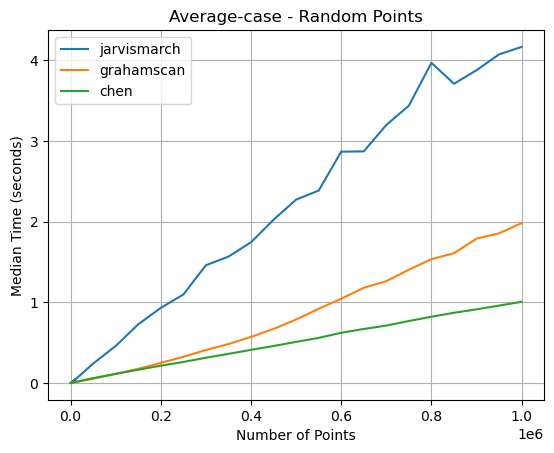

starting size: 10
algorithm: grahamscan
algorithm: chen
algorithm: grahamscan
algorithm: chen
algorithm: grahamscan
algorithm: chen
algorithm: grahamscan
algorithm: chen
algorithm: grahamscan
algorithm: chen
algorithm: grahamscan
algorithm: chen
algorithm: grahamscan
algorithm: chen
algorithm: grahamscan
algorithm: chen
algorithm: grahamscan
algorithm: chen
algorithm: grahamscan
algorithm: chen
starting size: 20
algorithm: grahamscan
algorithm: chen
algorithm: grahamscan
algorithm: chen
algorithm: grahamscan
algorithm: chen
algorithm: grahamscan
algorithm: chen
algorithm: grahamscan
algorithm: chen
algorithm: grahamscan
algorithm: chen
algorithm: grahamscan
algorithm: chen
algorithm: grahamscan
algorithm: chen
algorithm: grahamscan
algorithm: chen
algorithm: grahamscan
algorithm: chen
starting size: 30
algorithm: grahamscan
algorithm: chen
algorithm: grahamscan
algorithm: chen
algorithm: grahamscan
algorithm: chen
algorithm: grahamscan
algorithm: chen
algorithm: grahamscan
algorithm: c

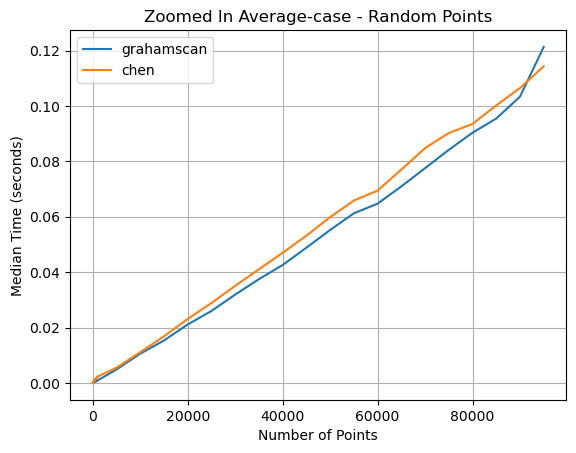

starting size: 10
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
starting size: 100
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
alg

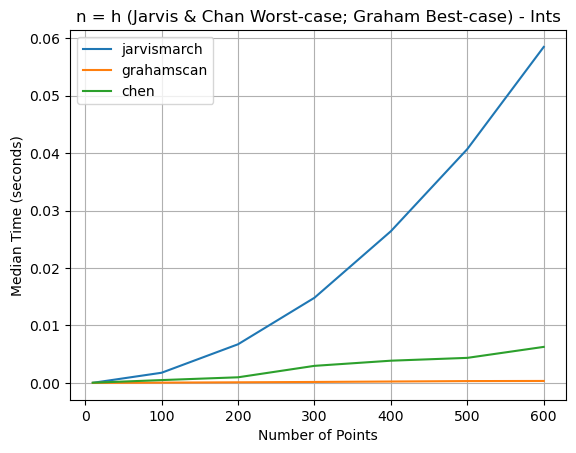

starting size: 3
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
starting size: 4
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algori

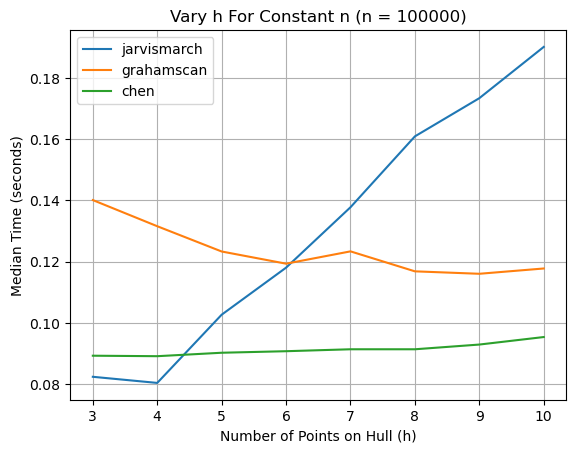

starting size: 3
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
starting size: 4
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algori

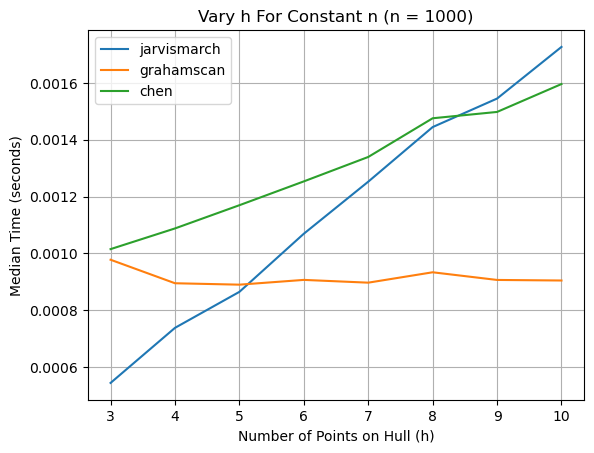

h: 3
h: 4
h: 5
ratio: 0.01
ratio: 0.05
ratio: 0.1
ratio: 0.2
ratio: 0.3
ratio: 0.4
ratio: 0.5
ratio: 0.6
ratio: 0.7
ratio: 0.8
ratio: 0.9
ratio: 1


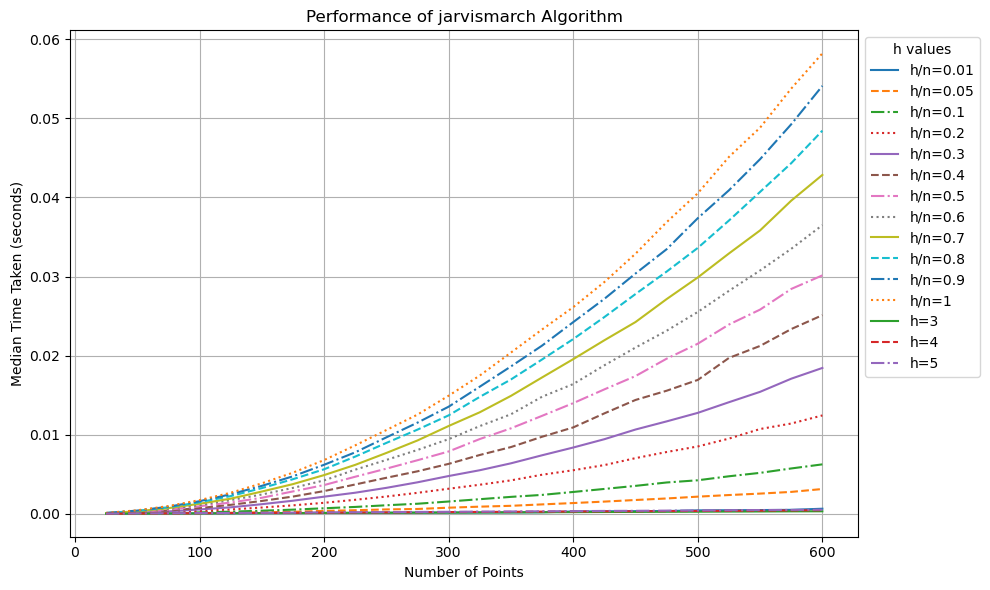

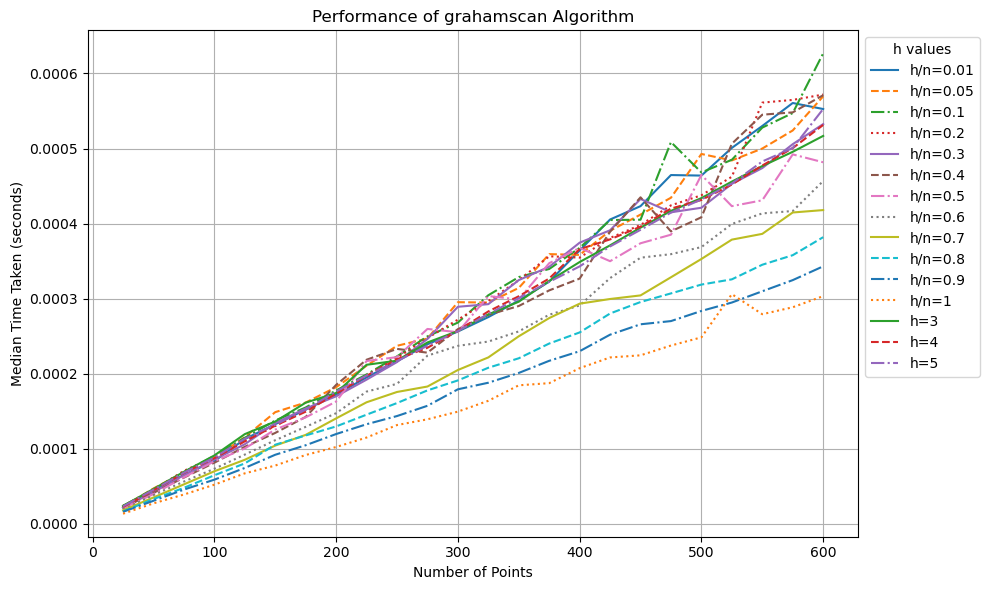

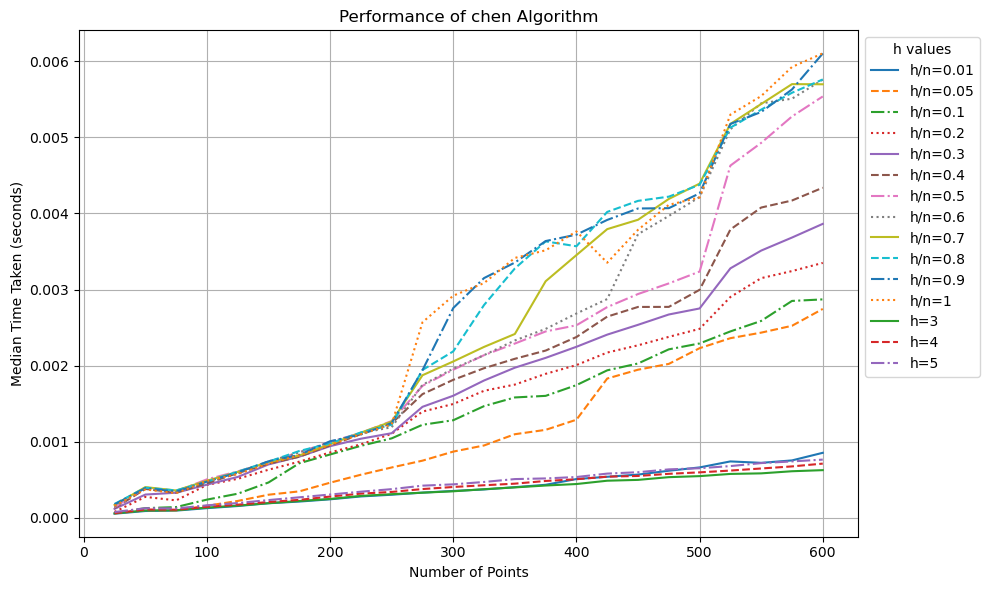

starting size: 10
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
starting size: 100
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
algorithm: chen
algorithm: jarvismarch
algorithm: grahamscan
alg

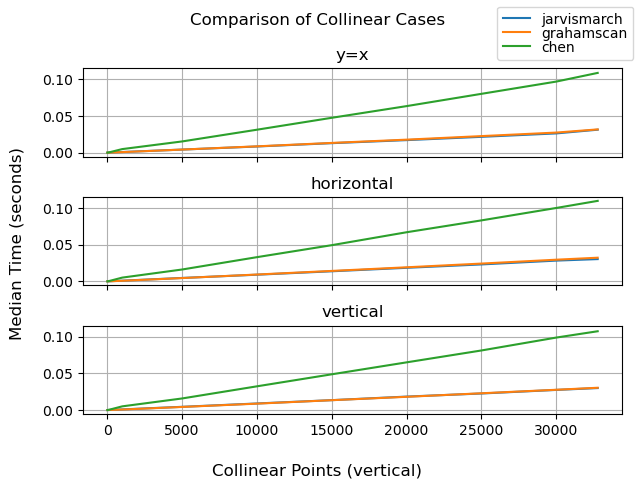

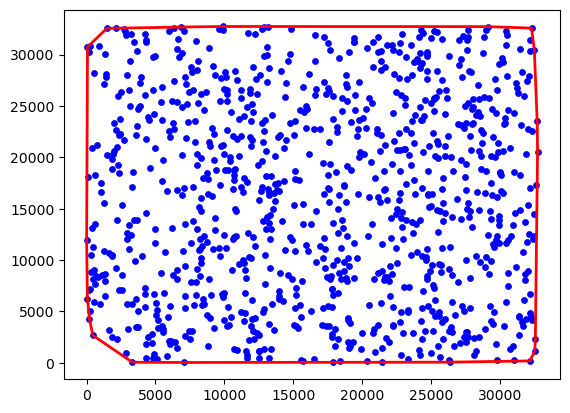

<Figure size 1500x1500 with 0 Axes>

In [6]:
import math
import random
import timeit
from matplotlib import pyplot as plt

if __name__ == "__main__":

    # average-case up to 1 million n
    framework = ExperimentalFramework(
        [jarvismarch, grahamscan, chen],
        10,
        [100 * i for i in range(1, 101)] + [50000 * i for i in range(1, 21)], # ~16 mins to run
        (0, 32767),
        (0, 32767),
    )
    framework.varyingN()
    framework.graphResults("Average-case - Random Points")

    # zoomed in average-case - when chan overtakes graham
    framework.resetResults([10 * i for i in range(1, 101)] + [5000 * i for i in range(1, 20)], [grahamscan, chen]) # ~30 secs to run
    framework.varyingN()
    framework.graphResults("Zoomed In Average-case - Random Points")

    # n = h from 10 - 600 (ints)
    framework.resetResults([10] + [100 * i for i in range(1, 7)], [jarvismarch, grahamscan, chen]) # ~2 sec to run
    framework.varyingNForHEquivalent()
    framework.graphResults("n = h (Jarvis & Chan Worst-case; Graham Best-case) - Ints")

    # h = 3 to 10 for n = 100000
    framework.resetResults([i for i in range(3, 11)]) # ~1 min to run
    framework.varySmallHForConstN(100000)
    framework.graphResults("Vary h For Constant n (n = 100000)", "Number of Points on Hull (h)")

    # h = 3 to 10 for n = 1000
    framework.resetResults([i for i in range(3, 11)]) # ~1 secs to run
    framework.varySmallHForConstN(1000)
    framework.graphResults("Vary h For Constant n (n = 1000)", "Number of Points on Hull (h)")

    # each algorithm individually - vary h specifically as n varies, then vary h/n as n varies
    framework.resetResults([25 * i for i in range(1, 25)]) # ~40 secs to run
    framework.graphIndividualAlgorithms([3, 4, 5], [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

    # performance of all 3 in situations y = x; y = a; & x = a; (where a is an integer) can only go up to 32767 due to the [0, 32767] constraint
    framework.resetResults([10, 100, 1000] + [5000 * i for i in range(1, 7)] + [framework.dataGenerator.xRange[1]]) # ~17 secs to run
    framework.graphResultsCollinearCases()

    # example of visualising the convex hull
    framework.dataGenerator.generateRandomPoints(1000) # almost instantly runs
    framework.visualiseHull(jarvismarch)